<a href="https://colab.research.google.com/github/gorovuha/text_generation/blob/main/ruwordnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install numpy scikit-learn compress-fasttext xmltodict matplotlib

In [ ]:
!pip install ruwordnet

In [6]:
!ruwordnet download

downloading a ruwordnet model from https://github.com/avidale/python-ruwordnet/releases/download/0.0.4/ruwordnet-2021.db


In [7]:
from ruwordnet import RuWordNet
wn = RuWordNet()

In [8]:
len(wn.synsets), len(wn.senses)

(59905, 154111)

In [9]:
import numpy as np
import compress_fasttext

from collections import Counter
from sklearn.neighbors import KDTree

import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
from gensim.models.fasttext import ft_ngram_hashes
ft = compress_fasttext.models.CompressedFastTextKeyedVectors.load(
    '/content/geowac_tokens_sg_300_5_2020-100K-20K-100.bin'
)

In [12]:
def vectorize(text):
    vec = np.mean([ft[word] for word in text.lower().split() if len(word) >= 3], axis=0)
    vec /= sum(vec**2) ** 0.5 
    return vec

def distance2vote(d, a=3, b=5):
    sim = np.maximum(0, 1 - d**2/2)
    return np.exp(-d**a) * sim **b

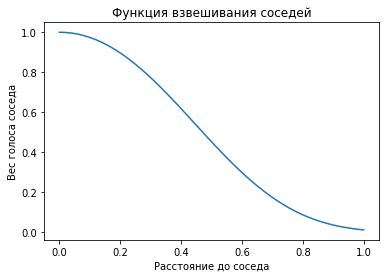

In [13]:
x = np.linspace(0, 1)
plt.plot(x, distance2vote(x))
plt.xlabel('Расстояние до соседа')
plt.ylabel('Вес голоса соседа')
plt.title('Функция взвешивания соседей');

In [14]:
from tqdm.auto import tqdm, trange

In [17]:
words, vectors, synset_ids = [], [], []
for synset in tqdm(wn.synsets):
    if synset.part_of_speech != 'V':
        continue
    for sense in synset.senses:
        words.append(sense.name)
        vectors.append(vectorize(sense.name))
        synset_ids.append(synset.id)
vectors = np.stack(vectors)
tree = KDTree(vectors)

  0%|          | 0/59905 [00:00<?, ?it/s]

In [28]:
votes = Counter()
dists, ids = tree.query(vectorize('лежать').reshape(1, -1), k=100)
for idx, distance in zip(ids[0], dists[0]):
    #for hyper in wn[synset_ids[idx]].hypernyms:
     #   votes[hyper.id] += distance2vote(distance)
    for syn in wn[synset_ids[idx]].pos_synonyms:
        votes[syn.id] += distance2vote(distance)
    for ant in wn[synset_ids[idx]].antonyms:
        votes[ant.id] += distance2vote(distance)

In [29]:
for sid, score in votes.most_common(10):
    print(score,  wn[sid].title)

1.9961170343147885 ЛЕЖАТЬ В СТАЦИОНАРЕ
1.4316198113860397 ЛЕЖАТЬ (НАХОДИТЬСЯ ВСЕМ ТЕЛОМ НА ПОВЕРХНОСТИ)
1.4316198113860397 ЛЕЖАТЬ (НАХОДИТЬСЯ ВСЕМ ТЕЛОМ НА ПОВЕРХНОСТИ)
1.3385958341412265 ЛЕЖАТЬ (НАХОДИТЬСЯ О ПРЕДМЕТАХ (ГОРИЗОНТАЛЬНО)
1.3385958341412265 ЛЕЖАТЬ (НАХОДИТЬСЯ О ПРЕДМЕТАХ (ГОРИЗОНТАЛЬНО)
1.0 ПРОЛЕГАТЬ, ПРОХОДИТЬ
0.556461916048211 РАЗЛЕЖИВАТЬСЯ БЕЗ ДЕЛА
0.19468962226572223 БЕССОЗНАТЕЛЬНОЕ СОСТОЯНИЕ
0.19468962226572223 БЕССОЗНАТЕЛЬНОЕ СОСТОЯНИЕ
0.18157607312486423 ПОЛУСИДЯЧЕЕ ПОЛОЖЕНИЕ
